In [1]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/aaa_ml/datasets/"

Mounted at /content/drive


In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import regex as re

from collections import Counter
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from gensim.models import FastText

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

In [6]:
with open(way + 'image_embeddings.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings.shape

(2456, 512)

In [8]:
df = pd.read_csv(way + 'data_split_into_classes.csv')
df.shape

(2456, 3)

In [9]:
df.head()

,item_id,image_id,title
0,928428250447,9930449149,Беговая дорожка laufstein corsa automatik
1,172952000262,1770341493,Эллиптический тренажер Torneo Vento C-208
2,1064720000255,11289835148,Эллиптический тренажер
3,660092751953,5126102753,Гантели по 10 кг каждая
4,258603750759,2318932240,Kettler Delta XL


In [22]:
df_titles = pd.read_csv(way + 'more_titles.csv')
df_titles = pd.concat([df_titles['title'], df['title']]).reset_index()
df_titles.shape

(100316, 2)

In [23]:
WORD_PATTERN = '(?u)\\b\\w\\w+\\b'
reg_exp = re.compile(pattern=WORD_PATTERN)
sentences = [reg_exp.findall(s.lower()) for s in df_titles['title']]

In [29]:
ft_model = FastText(vector_size=200, window=6, min_count=1, sg = 1)
ft_model.build_vocab(sentences)
ft_model.train(
    corpus_iterable=sentences,
    total_examples=ft_model.corpus_count,
    epochs=20,
    compute_loss=True)

(7454396, 9080260)

In [32]:
ft_model.wv.similar_by_word('samsung')

[('ip68', 0.8650945425033569),
 ('coldgear', 0.8612498044967651),
 ('teslawatch', 0.8585818409919739),
 ('vwar', 0.8570824861526489),
 ('sanofi', 0.8559780716896057),
 ('5c', 0.8543248176574707),
 ('abmit2', 0.8511467576026917),
 ('y2', 0.851007878780365),
 ('iwown', 0.8508213758468628),
 ('4s', 0.8503427505493164)]

In [33]:
class FtTransformer:

    def __init__(self, model, word_pattern):

        self.model = model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):

        X_transformed = np.zeros((len(X), self.model.wv.vector_size))
        for i, title in enumerate(X):

            title_vector = np.zeros((self.model.wv.vector_size,))
            tokens = self.re.findall(title.lower())
            if len(tokens) == 0:
              continue

            for token in tokens:
                if token in self.model.wv.key_to_index:
                    title_vector += self.model.wv.get_vector(token)

            X_transformed[i] = title_vector / len(tokens)

        return X_transformed

In [35]:
ft_transformer = FtTransformer(model=ft_model, word_pattern=WORD_PATTERN)

train_ft = ft_transformer.transform(df['title'].values)

In [36]:
train_ft.shape

(2456, 200)

# Изменение размерности

In [60]:
pca = PCA(n_components=70)

reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings.shape

(2456, 70)

In [61]:
pca_text = PCA(n_components=70)

reduced_texts = pca_text.fit_transform(train_ft)
reduced_texts.shape

(2456, 70)

In [62]:
df_for_clus = np.hstack([reduced_texts, reduced_embeddings])
df_for_clus.shape

(2456, 140)

In [63]:
RAND = 17

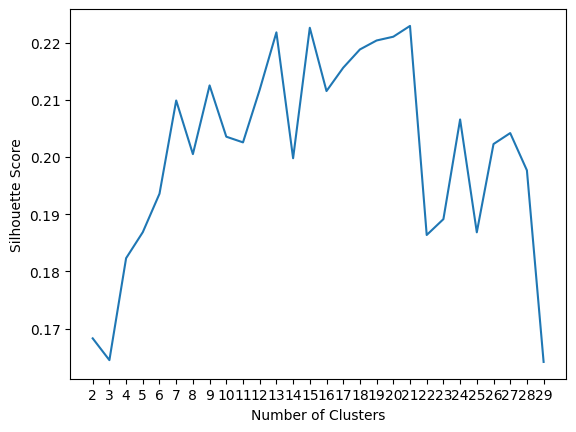

In [64]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 15,
    "random_state": RAND,
}

silhouette_coefficients = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_for_clus)
    score = silhouette_score(df_for_clus, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(2, 30), silhouette_coefficients)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

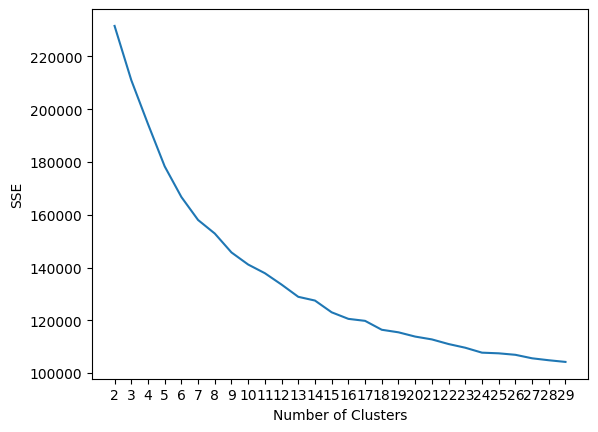

In [65]:
kmeans_kwargs = {
"init": "random",
"n_init": 15,
"random_state": RAND,
}

sses = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs, algorithm="lloyd")
    kmeans.fit(df_for_clus)
    sses.append(kmeans.inertia_)

plt.plot(range(2, 30), sses)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [96]:
kmeans = KMeans(n_clusters=20, **kmeans_kwargs)
kmeans.fit(df_for_clus)

KMeans(init='random', n_clusters=20, n_init=15, random_state=17)

In [98]:
pd.DataFrame(kmeans.labels_).to_csv('solution.csv', header=['cluster'], index=False)

# DBSCAN

In [72]:
pca = PCA(n_components=40)

reduced_embeddings2 = pca.fit_transform(embeddings)
reduced_embeddings2.shape

(2456, 40)

In [73]:
pca_text = PCA(n_components=40)

reduced_texts2 = pca_text.fit_transform(train_ft)
reduced_texts2.shape

(2456, 40)

In [74]:
df_for_clus2 = np.hstack([reduced_texts2, reduced_embeddings2])
df_for_clus2.shape

(2456, 80)

In [77]:
df_for_clus2

array([[-1.47176354,  2.39852272, -0.02392759, ...,  0.65115064,
        -0.42841035,  0.32719296],
       [-1.80219742, -1.35678983,  0.23761845, ..., -0.20993237,
        -0.39450014,  0.32330659],
       [-2.48949869, -2.20965879, -0.13111482, ...,  0.24350506,
         0.17876586,  0.99812943],
       ...,
       [-0.42735399, -0.28480543, -0.47043599, ...,  0.37001392,
         0.69061303, -0.03615455],
       [-0.41571056,  1.4635395 , -0.58447228, ...,  0.12447991,
        -0.25604033, -0.80809587],
       [ 1.81431696,  0.31152545, -0.35272586, ...,  0.39902639,
        -1.00704527, -0.60888118]])

In [85]:
eps_values = [1.5, 1.8, 2, 2.1, 2.5]
min_samples_values = range(2, 10)

best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = db.fit_predict(train_ft)

        if len(set(clusters)) > 1:
            score = silhouette_score(train_ft, clusters)

            # Сохранение параметров, дающих наилучший силуэтный коэффициент
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}


In [86]:
print(f"Best silhouette score: {best_score}")
print(f"Best parameters: {best_params}")

Best silhouette score: 0.0871186777927508
Best parameters: {'eps': 2.5, 'min_samples': 9}


# GMM

In [90]:
n_components_range = range(2, 25)  # Например, от 2 до 10

# Определение различных типов ковариационных матриц
covariance_types = ['spherical', 'diag', 'tied', 'full']

best_score = -1
best_params = {}

for n_components in n_components_range:
    for covariance_type in covariance_types:
        # Создание и обучение модели GMM с текущими параметрами
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=RAND)
        gmm.fit(reduced_texts2)
        labels = gmm.predict(reduced_texts2)

        # Вычисление силуэтного коэффициента
        if len(set(labels)) > 1:  # Проверка наличия более одного кластера
            score = silhouette_score(reduced_texts2, labels)

            # Сохранение параметров, дающих наилучший силуэтный коэффициент
            if score > best_score:
                best_score = score
                best_params = {
                    'n_components': n_components,
                    'covariance_type': covariance_type
                }



In [91]:
print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.22916970258960268
Best Parameters: {'n_components': 7, 'covariance_type': 'tied'}


In [94]:
gmm = GaussianMixture(n_components=8, covariance_type='tied', random_state=RAND)
gmm.fit(reduced_texts2)
labels = gmm.predict(reduced_texts2)

In [95]:
pd.DataFrame(labels).to_csv('solution.csv', header=['cluster'], index=False)